## This Notebook contains trajectory analysis of different optimizers, but also different tests where we switched optimizers

### There is also a figure used in the report in the last cell

In [1]:
# GPU-Optimized Trajectory Class
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import time
from tqdm import tqdm

Using device: cuda
Starting MNIST Optimizer Trajectory Analysis...
Device: cuda
OPTIMIZER COMPARISON EXPERIMENT

Training with SGD...
Epoch: 0, Batch: 0, Loss: 2.287740
Epoch: 0, Batch: 100, Loss: 1.811472
Epoch: 0, Batch: 200, Loss: 1.002451
Epoch: 0, Batch: 300, Loss: 0.791977
Epoch: 0, Batch: 400, Loss: 0.507837
Epoch: 0, Batch: 500, Loss: 0.422036
Epoch: 0, Batch: 600, Loss: 0.479261
Epoch: 0, Batch: 700, Loss: 0.520999
Epoch: 0, Batch: 800, Loss: 0.354700
Epoch: 0, Batch: 900, Loss: 0.370079
Epoch 0: Test Loss: 0.3222, Accuracy: 90.70%
Epoch: 1, Batch: 0, Loss: 0.238553
Epoch: 1, Batch: 100, Loss: 0.287072
Epoch: 1, Batch: 200, Loss: 0.497832
Epoch: 1, Batch: 300, Loss: 0.288560
Epoch: 1, Batch: 400, Loss: 0.163089
Epoch: 1, Batch: 500, Loss: 0.362202
Epoch: 1, Batch: 600, Loss: 0.261744
Epoch: 1, Batch: 700, Loss: 0.240752
Epoch: 1, Batch: 800, Loss: 0.228711
Epoch: 1, Batch: 900, Loss: 0.263391
Epoch 1: Test Loss: 0.2524, Accuracy: 92.63%
Epoch: 2, Batch: 0, Loss: 0.271923
Epoch

TypeError: print_jpg() got an unexpected keyword argument 'quality'

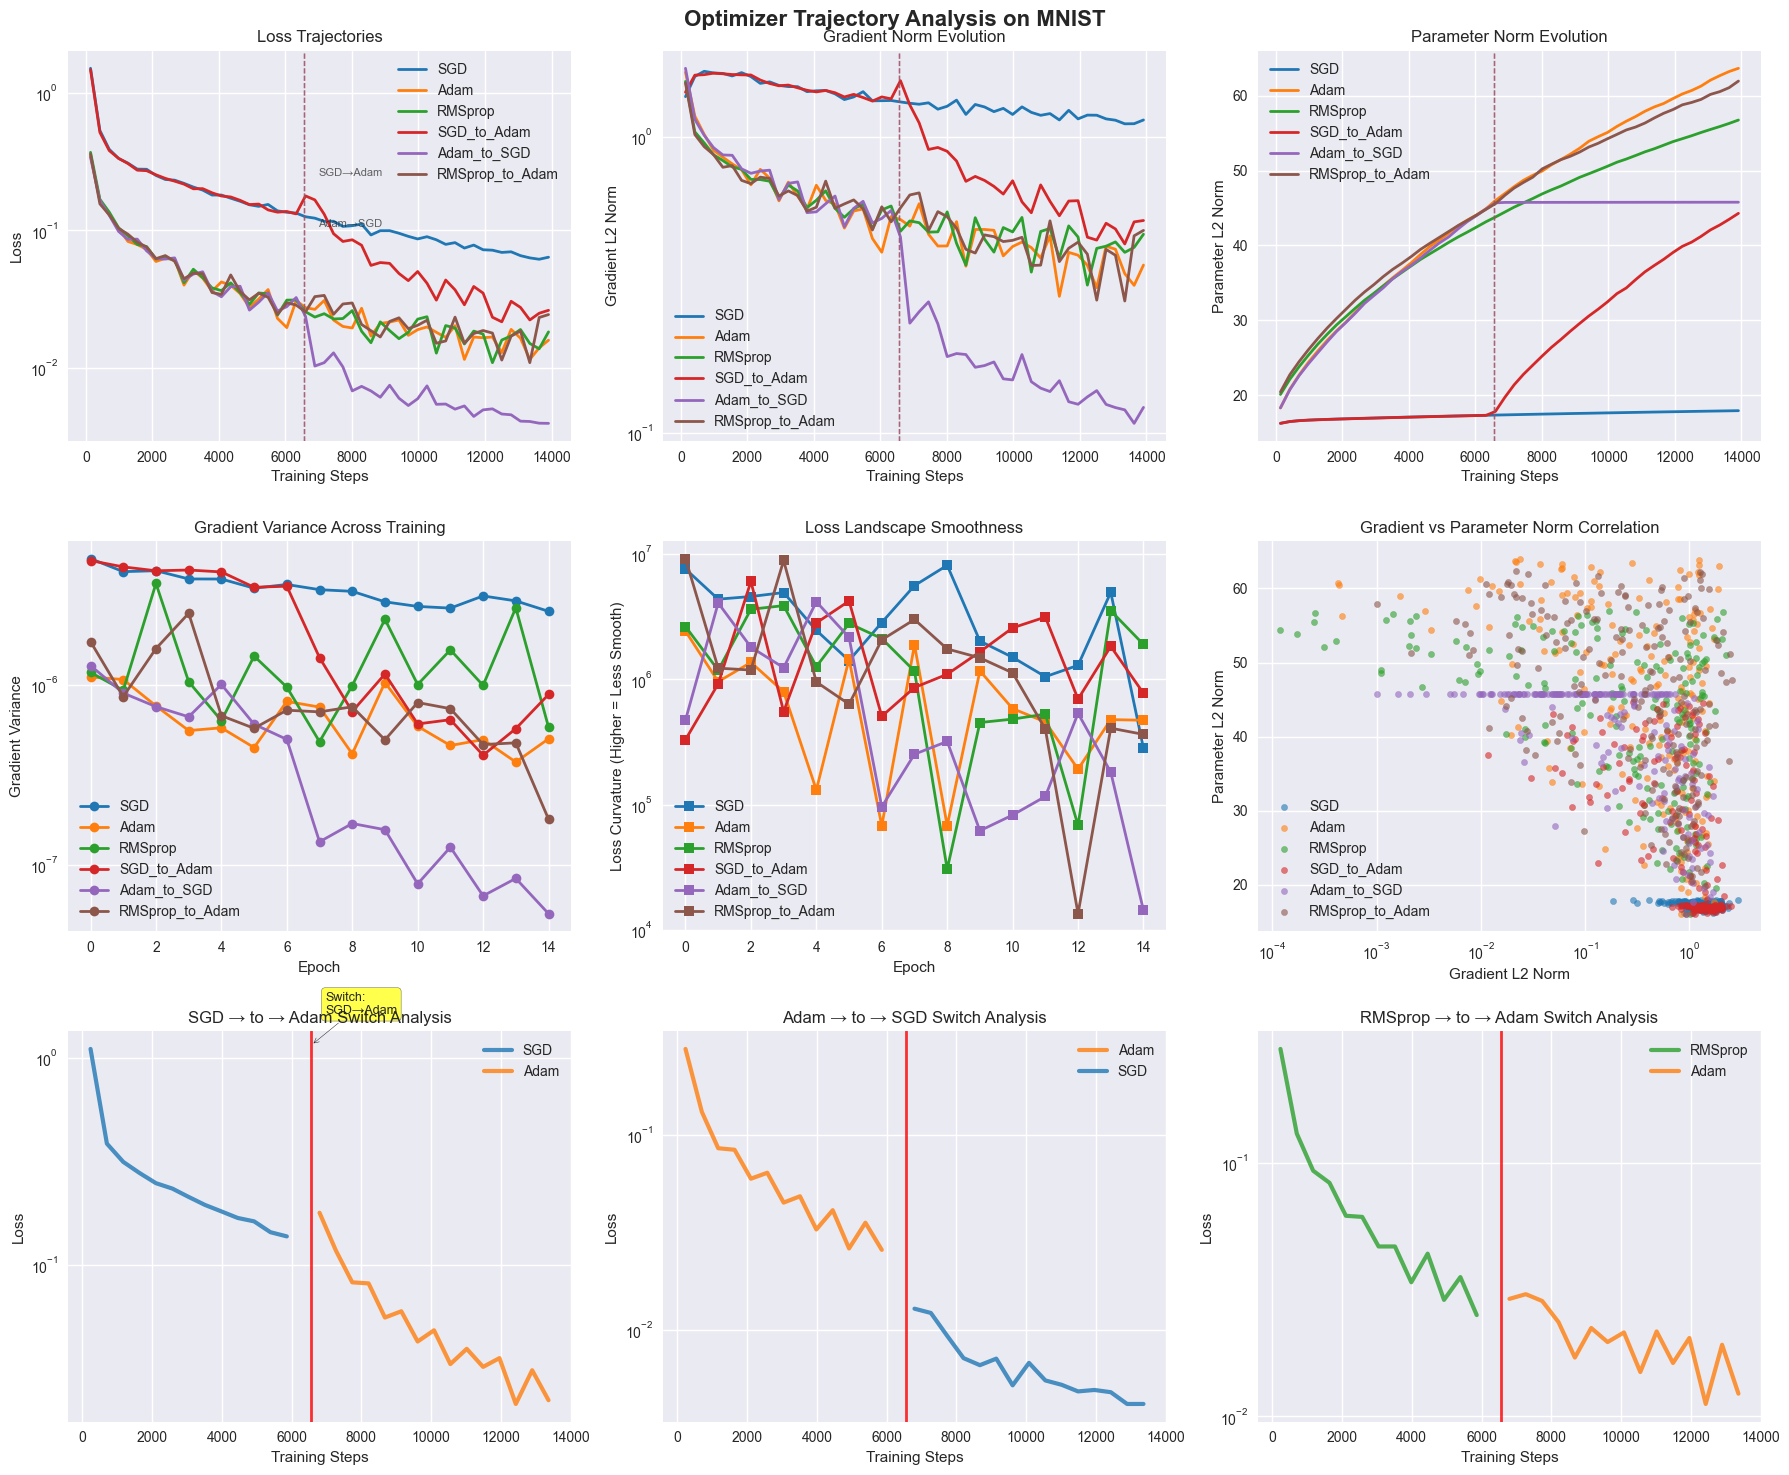

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy
import json
from datetime import datetime

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class MNISTNet(nn.Module):
    """Simple CNN for MNIST"""
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

class OptimizerTracker:
    """Tracks optimizer-specific metrics during training with continuous tracking for switches"""
    
    def __init__(self, experiment_name):
        self.experiment_name = experiment_name
        # Use unified keys for continuous tracking
        self.metrics = {
            'loss': [],
            'grad_norm': [],
            'param_norm': [],
            'step': [],
            'optimizer_used': [],  # Track which optimizer was used at each step
            'switch_points': []    # Track when switches occurred
        }
        self.epoch_metrics = {
            'grad_var': [],
            'loss_smoothness': [],
            'epoch': [],
            'optimizer_at_epoch': []
        }
        
    def compute_gradient_norm(self, model):
        """Compute L2 norm of gradients"""
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        return total_norm ** (1. / 2)
    
    def compute_parameter_norm(self, model):
        """Compute L2 norm of parameters"""
        total_norm = 0
        for p in model.parameters():
            param_norm = p.data.norm(2)
            total_norm += param_norm.item() ** 2
        return total_norm ** (1. / 2)
    
    def compute_gradient_variance(self, model, data_loader, criterion, num_samples=100):
        """Compute gradient variance across mini-batches"""
        model.eval()
        gradients = []
        
        for i, (data, target) in enumerate(data_loader):
            if i >= num_samples:
                break
                
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            # Compute gradients
            model.zero_grad()
            loss.backward()
            
            # Store flattened gradients
            grad_vector = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
            gradients.append(grad_vector.cpu().numpy())
        
        gradients = np.array(gradients)
        return np.var(gradients, axis=0).mean()
    
    def compute_loss_smoothness(self, model, data_loader, criterion, epsilon=1e-4):
        """Estimate loss smoothness via finite differences"""
        model.eval()
        original_params = [p.clone() for p in model.parameters()]
        
        # Compute original loss
        total_loss = 0
        count = 0
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            count += 1
            if count >= 10:  # Sample subset for efficiency
                break
        original_loss = total_loss / count
        
        # Add noise and compute perturbed loss
        with torch.no_grad():
            for p in model.parameters():
                noise = torch.randn_like(p) * epsilon
                p.add_(noise)
        
        total_loss_perturbed = 0
        count = 0
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss_perturbed += criterion(output, target).item()
            count += 1
            if count >= 10:
                break
        perturbed_loss = total_loss_perturbed / count
        
        # Restore original parameters
        for p, orig_p in zip(model.parameters(), original_params):
            p.data.copy_(orig_p)
        
        # Smoothness is inversely related to loss change
        smoothness = abs(perturbed_loss - original_loss) / (epsilon ** 2)
        return smoothness
    
    def mark_switch(self, step, from_optimizer, to_optimizer):
        """Mark when an optimizer switch occurs"""
        self.metrics['switch_points'].append({
            'step': step,
            'from': from_optimizer,
            'to': to_optimizer
        })
    
    def track_step(self, model, loss, optimizer_name, step):
        """Track metrics for a single step with continuous tracking"""
        grad_norm = self.compute_gradient_norm(model)
        param_norm = self.compute_parameter_norm(model)
        
        self.metrics['loss'].append(loss)
        self.metrics['grad_norm'].append(grad_norm)
        self.metrics['param_norm'].append(param_norm)
        self.metrics['step'].append(step)
        self.metrics['optimizer_used'].append(optimizer_name)
    
    def track_epoch(self, model, data_loader, criterion, optimizer_name, epoch):
        """Track epoch-level metrics"""
        grad_var = self.compute_gradient_variance(model, data_loader, criterion)
        loss_smoothness = self.compute_loss_smoothness(model, data_loader, criterion)
        
        self.epoch_metrics['grad_var'].append(grad_var)
        self.epoch_metrics['loss_smoothness'].append(loss_smoothness)
        self.epoch_metrics['epoch'].append(epoch)
        self.epoch_metrics['optimizer_at_epoch'].append(optimizer_name)

def train_with_optimizer(model, train_loader, test_loader, optimizer_name, 
                        epochs=10, lr=0.001, switch_epoch=None, switch_to=None):
    """Train model with specified optimizer, optionally switching mid-training"""
    
    model = model.to(device)
    criterion = nn.NLLLoss()
    
    # Create experiment name
    if switch_epoch is not None and switch_to is not None:
        experiment_name = f"{optimizer_name}_to_{switch_to}"
    else:
        experiment_name = optimizer_name
    
    tracker = OptimizerTracker(experiment_name)
    
    # Initialize optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    
    step = 0
    current_optimizer_name = optimizer_name
    
    for epoch in range(epochs):
        # Switch optimizer if specified
        if switch_epoch is not None and epoch == switch_epoch and switch_to is not None:
            print(f"Switching from {current_optimizer_name} to {switch_to} at epoch {epoch}")
            
            # Mark the switch point
            tracker.mark_switch(step, current_optimizer_name, switch_to)
            
            if switch_to == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif switch_to == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif switch_to == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            
            current_optimizer_name = switch_to
        
        model.train()
        epoch_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Track metrics before optimizer step
            tracker.track_step(model, loss.item(), current_optimizer_name, step)
            
            optimizer.step()
            step += 1
            epoch_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.6f}')
        
        # Track epoch-level metrics
        tracker.track_epoch(model, train_loader, criterion, current_optimizer_name, epoch)
        
        # Evaluate
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Epoch {epoch}: Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return tracker

def run_comparison_experiment():
    """Run comprehensive optimizer comparison"""
    
    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
    optimizers = ['SGD', 'Adam', 'RMSprop']
    epochs = 15
    lr = 0.001
    
    all_trackers = {}
    
    print("=" * 50)
    print("OPTIMIZER COMPARISON EXPERIMENT")
    print("=" * 50)
    
    # Experiment 1: Pure optimizer comparison
    for opt_name in optimizers:
        print(f"\nTraining with {opt_name}...")
        model = MNISTNet()
        tracker = train_with_optimizer(model, train_loader, test_loader, 
                                     opt_name, epochs=epochs, lr=lr)
        all_trackers[opt_name] = tracker
    
    # Experiment 2: Mid-training switches
    switch_experiments = [
        ('SGD', 'Adam', 7),
        ('Adam', 'SGD', 7),
        ('RMSprop', 'Adam', 7)
    ]
    
    print("\n" + "=" * 50)
    print("MID-TRAINING SWITCH EXPERIMENTS")
    print("=" * 50)
    
    for start_opt, end_opt, switch_epoch in switch_experiments:
        print(f"\nTraining with {start_opt} -> {end_opt} switch at epoch {switch_epoch}...")
        model = MNISTNet()
        tracker = train_with_optimizer(model, train_loader, test_loader, 
                                     start_opt, epochs=epochs, lr=lr,
                                     switch_epoch=switch_epoch, switch_to=end_opt)
        all_trackers[f'{start_opt}_to_{end_opt}'] = tracker
    
    return all_trackers

def plot_trajectory_analysis(all_trackers):
    """Create comprehensive plots of optimizer trajectories with proper switch handling"""
    
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Optimizer Trajectory Analysis on MNIST', fontsize=16, fontweight='bold')
    
    # Color scheme
    colors = {
        'SGD': '#1f77b4',
        'Adam': '#ff7f0e', 
        'RMSprop': '#2ca02c',
        'SGD_to_Adam': '#d62728',
        'Adam_to_SGD': '#9467bd',
        'RMSprop_to_Adam': '#8c564b'
    }
    
    # Plot 1: Loss trajectories with continuous lines for switches
    ax = axes[0, 0]
    for name, tracker in all_trackers.items():
        loss_vals = tracker.metrics['loss']
        steps = tracker.metrics['step']
        
        if len(loss_vals) > 100:
            # Smooth the loss curve
            window = max(1, len(loss_vals) // 50)
            loss_smooth = []
            steps_smooth = []
            
            for i in range(0, len(loss_vals) - window, window):
                loss_smooth.append(np.mean(loss_vals[i:i+window]))
                steps_smooth.append(np.mean(steps[i:i+window]))
            
            ax.plot(steps_smooth, loss_smooth, label=name, color=colors.get(name, 'black'), linewidth=2)
            
            # Mark switch points if they exist
            for switch in tracker.metrics.get('switch_points', []):
                switch_step = switch['step']
                # Find the corresponding loss value at switch point
                switch_idx = min(range(len(steps)), key=lambda i: abs(steps[i] - switch_step))
                ax.axvline(x=switch_step, color=colors.get(name, 'black'), 
                          linestyle='--', alpha=0.5, linewidth=1)
                ax.annotate(f'{switch["from"]}→{switch["to"]}', 
                           xy=(switch_step, loss_vals[switch_idx]), 
                           xytext=(10, 10), textcoords='offset points',
                           fontsize=8, alpha=0.7)
    
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Trajectories')
    ax.legend()
    ax.set_yscale('log')
    
    # Plot 2: Gradient norms with continuous tracking
    ax = axes[0, 1]
    for name, tracker in all_trackers.items():
        grad_norms = tracker.metrics['grad_norm']
        steps = tracker.metrics['step']
        
        if len(grad_norms) > 100:
            window = max(1, len(grad_norms) // 50)
            grad_smooth = []
            steps_smooth = []
            
            for i in range(0, len(grad_norms) - window, window):
                grad_smooth.append(np.mean(grad_norms[i:i+window]))
                steps_smooth.append(np.mean(steps[i:i+window]))
            
            ax.plot(steps_smooth, grad_smooth, label=name, color=colors.get(name, 'black'), linewidth=2)
            
            # Mark switch points
            for switch in tracker.metrics.get('switch_points', []):
                ax.axvline(x=switch['step'], color=colors.get(name, 'black'), 
                          linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Gradient L2 Norm')
    ax.set_title('Gradient Norm Evolution')
    ax.legend()
    ax.set_yscale('log')
    
    # Plot 3: Parameter norms
    ax = axes[0, 2]
    for name, tracker in all_trackers.items():
        param_norms = tracker.metrics['param_norm']
        steps = tracker.metrics['step']
        
        if len(param_norms) > 100:
            window = max(1, len(param_norms) // 50)
            param_smooth = []
            steps_smooth = []
            
            for i in range(0, len(param_norms) - window, window):
                param_smooth.append(np.mean(param_norms[i:i+window]))
                steps_smooth.append(np.mean(steps[i:i+window]))
            
            ax.plot(steps_smooth, param_smooth, label=name, color=colors.get(name, 'black'), linewidth=2)
            
            # Mark switch points
            for switch in tracker.metrics.get('switch_points', []):
                ax.axvline(x=switch['step'], color=colors.get(name, 'black'), 
                          linestyle='--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Parameter L2 Norm')
    ax.set_title('Parameter Norm Evolution')
    ax.legend()
    
    # Plot 4: Gradient variance (epoch level)
    ax = axes[1, 0]
    for name, tracker in all_trackers.items():
        grad_vars = tracker.epoch_metrics['grad_var']
        epochs = tracker.epoch_metrics['epoch']
        ax.plot(epochs, grad_vars, 'o-', label=name, color=colors.get(name, 'black'), linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Variance')
    ax.set_title('Gradient Variance Across Training')
    ax.legend()
    ax.set_yscale('log')
    
    # Plot 5: Loss smoothness
    ax = axes[1, 1]
    for name, tracker in all_trackers.items():
        smoothness = tracker.epoch_metrics['loss_smoothness']
        epochs = tracker.epoch_metrics['epoch']
        ax.plot(epochs, smoothness, 's-', label=name, color=colors.get(name, 'black'), linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss Curvature (Higher = Less Smooth)')
    ax.set_title('Loss Landscape Smoothness')
    ax.legend()
    ax.set_yscale('log')
    
    # Plot 6: Gradient norm vs Parameter norm correlation
    ax = axes[1, 2]
    for name, tracker in all_trackers.items():
        grad_norms = tracker.metrics['grad_norm']
        param_norms = tracker.metrics['param_norm']
        
        # Sample points for scatter plot
        n_points = min(200, len(grad_norms))
        indices = np.linspace(0, len(grad_norms)-1, n_points, dtype=int)
        
        ax.scatter([grad_norms[i] for i in indices], 
                  [param_norms[i] for i in indices],
                  alpha=0.6, label=name, color=colors.get(name, 'black'), s=20)
    
    ax.set_xlabel('Gradient L2 Norm')
    ax.set_ylabel('Parameter L2 Norm')
    ax.set_title('Gradient vs Parameter Norm Correlation')
    ax.legend()
    ax.set_xscale('log')
    
    # Plot 7-9: Focus on switch experiments with detailed views
    switch_experiments = ['SGD_to_Adam', 'Adam_to_SGD', 'RMSprop_to_Adam']
    
    for i, switch_name in enumerate(switch_experiments):
        ax = axes[2, i]
        if switch_name in all_trackers:
            tracker = all_trackers[switch_name]
            
            # Plot loss with detailed switch visualization
            loss_vals = tracker.metrics['loss']
            steps = tracker.metrics['step']
            optimizers_used = tracker.metrics['optimizer_used']
            
            if len(loss_vals) > 50:
                window = max(1, len(loss_vals) // 30)
                
                # Create segments based on optimizer used
                current_opt = optimizers_used[0]
                segment_start = 0
                
                for j in range(len(optimizers_used)):
                    if optimizers_used[j] != current_opt or j == len(optimizers_used) - 1:
                        # End of current segment
                        segment_end = j if j != len(optimizers_used) - 1 else j + 1
                        
                        # Extract and smooth this segment
                        segment_loss = loss_vals[segment_start:segment_end]
                        segment_steps = steps[segment_start:segment_end]
                        
                        if len(segment_loss) > window:
                            loss_smooth = [np.mean(segment_loss[k:k+window]) for k in range(0, len(segment_loss)-window, window)]
                            steps_smooth = [np.mean(segment_steps[k:k+window]) for k in range(0, len(segment_loss)-window, window)]
                        else:
                            loss_smooth = segment_loss
                            steps_smooth = segment_steps
                        
                        # Plot segment with optimizer-specific color
                        pure_opt_color = colors.get(current_opt, 'black')
                        ax.plot(steps_smooth, loss_smooth, 
                               color=pure_opt_color, linewidth=3, alpha=0.8,
                               label=f'{current_opt}' if current_opt not in [l.get_label() for l in ax.lines] else "")
                        
                        # Update for next segment
                        current_opt = optimizers_used[j] if j < len(optimizers_used) else current_opt
                        segment_start = j
                
                # Mark switch points prominently
                for switch in tracker.metrics.get('switch_points', []):
                    ax.axvline(x=switch['step'], color='red', linestyle='-', alpha=0.8, linewidth=2)
                    ax.annotate(f'Switch:\n{switch["from"]}→{switch["to"]}', 
                               xy=(switch['step'], max(loss_vals) * 0.5), 
                               xytext=(10, 20), textcoords='offset points',
                               fontsize=9, ha='left', va='bottom',
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
            
            ax.set_xlabel('Training Steps')
            ax.set_ylabel('Loss')
            ax.set_title(f'{switch_name.replace("_", " → ")} Switch Analysis')
            ax.legend()
            ax.set_yscale('log')
    
    plt.tight_layout()
    
    # Save as JPEG with high quality
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'optimizer_analysis_{timestamp}.jpg', format='jpeg', dpi=300, bbox_inches='tight', quality=95)
    print(f"Plot saved as optimizer_analysis_{timestamp}.jpg")
    
    plt.show()

def analyze_optimizer_properties(all_trackers):
    """Analyze and compare key properties of different optimizers"""
    
    print("\n" + "=" * 60)
    print("OPTIMIZER PROPERTY ANALYSIS")
    print("=" * 60)
    
    properties = {}
    
    for name, tracker in all_trackers.items():
        properties[name] = {}
        
        # Extract final metrics using unified keys
        loss_vals = tracker.metrics['loss']
        grad_norms = tracker.metrics['grad_norm']
        param_norms = tracker.metrics['param_norm']
        
        if loss_vals:
            final_loss = np.mean(loss_vals[-100:])  # Average of last 100 steps
            properties[name]['final_loss'] = final_loss
            
            # Loss convergence stability (coefficient of variation in final phase)
            final_losses = loss_vals[-200:]
            if len(final_losses) > 10:
                properties[name]['loss_stability'] = np.std(final_losses) / np.mean(final_losses)
        
        if grad_norms:
            final_grad_norm = np.mean(grad_norms[-100:])
            properties[name]['final_grad_norm'] = final_grad_norm
            
            # Gradient norm decay rate
            if len(grad_norms) > 100:
                early_grad = np.mean(grad_norms[50:150])
                late_grad = np.mean(grad_norms[-100:])
                properties[name]['grad_decay_rate'] = (early_grad - late_grad) / early_grad if early_grad > 0 else 0
        
        if param_norms:
            properties[name]['final_param_norm'] = param_norms[-1]
            properties[name]['param_growth'] = (param_norms[-1] - param_norms[0]) / param_norms[0] if param_norms[0] > 0 else 0
        
        # Epoch-level metrics
        grad_vars = tracker.epoch_metrics['grad_var']
        smoothness_vals = tracker.epoch_metrics['loss_smoothness']
        
        if grad_vars:
            properties[name]['avg_grad_variance'] = np.mean(grad_vars)
        
        if smoothness_vals:
            properties[name]['avg_loss_smoothness'] = np.mean(smoothness_vals)
        
        # Count number of switches
        properties[name]['num_switches'] = len(tracker.metrics.get('switch_points', []))
    
    # Print comparison table
    print(f"{'Optimizer':<20} {'Final Loss':<12} {'Loss Stab':<10} {'Grad Norm':<12} {'Grad Decay':<11} {'Param Growth':<12} {'Switches':<8}")
    print("-" * 95)
    
    for name, props in properties.items():
        print(f"{name:<20} "
              f"{props.get('final_loss', 0):<12.4f} "
              f"{props.get('loss_stability', 0):<10.4f} "
              f"{props.get('final_grad_norm', 0):<12.4f} "
              f"{props.get('grad_decay_rate', 0):<11.3f} "
              f"{props.get('param_growth', 0):<12.3f} "
              f"{props.get('num_switches', 0):<8d}")
    
    print("\n" + "=" * 60)
    print("KEY FINDINGS:")
    print("=" * 60)
    
    # Find best performers
    pure_optimizers = ['SGD', 'Adam', 'RMSprop']
    pure_props = {k: v for k, v in properties.items() if k in pure_optimizers}
    
    if pure_props:
        best_loss = min(pure_props.items(), key=lambda x: x[1].get('final_loss', float('inf')))
        print(f"• Lowest final loss: {best_loss[0]} ({best_loss[1]['final_loss']:.4f})")
        
        most_stable = min(pure_props.items(), key=lambda x: x[1].get('loss_stability', float('inf')))
        print(f"• Most stable convergence: {most_stable[0]} (CV: {most_stable[1]['loss_stability']:.4f})")
        
        fastest_decay = max(pure_props.items(), key=lambda x: x[1].get('grad_decay_rate', 0))
        print(f"• Fastest gradient decay: {fastest_decay[0]} ({fastest_decay[1]['grad_decay_rate']:.3f})")
    
    # Analyze switch experiments
    switch_names = [k for k in properties.keys() if '_to_' in k]
    if switch_names:
        print(f"\n• Switch experiment results:")
        for switch_name in switch_names:
            parts = switch_name.split('_to_')
            if len(parts) == 2:
                start_opt, end_opt = parts
                switch_loss = properties[switch_name].get('final_loss', 0)
                pure_start_loss = properties.get(start_opt, {}).get('final_loss', 0)
                pure_end_loss = properties.get(end_opt, {}).get('final_loss', 0)
                
                print(f"  - {start_opt}→{end_opt}: {switch_loss:.4f} "
                      f"(vs pure {start_opt}: {pure_start_loss:.4f}, pure {end_opt}: {pure_end_loss:.4f})")
    
    return properties

def save_results(all_trackers, properties):
    """Save experimental results to files"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save raw tracking data
    results = {}
    for name, tracker in all_trackers.items():
        results[name] = {
            'step_metrics': dict(tracker.metrics),
            'epoch_metrics': dict(tracker.epoch_metrics)
        }
    
    with open(f'optimizer_trajectories_{timestamp}.json', 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        serializable_results = {}
        for name, data in results.items():
            serializable_results[name] = {}
            for metric_type, metrics in data.items():
                serializable_results[name][metric_type] = {}
                for metric_name, values in metrics.items():
                    if isinstance(values, list):
                        serializable_results[name][metric_type][metric_name] = values
                    else:
                        serializable_results[name][metric_type][metric_name] = str(values)
        
        json.dump(serializable_results, f, indent=2)
    
    # Save analysis summary
    with open(f'optimizer_analysis_{timestamp}.json', 'w') as f:
        json.dump(properties, f, indent=2)
    
    print(f"\nResults saved:")
    print(f"• Raw data: optimizer_trajectories_{timestamp}.json")
    print(f"• Analysis: optimizer_analysis_{timestamp}.json")

if __name__ == "__main__":
    print("Starting MNIST Optimizer Trajectory Analysis...")
    print(f"Device: {device}")
    
    # Run the full experiment
    all_trackers = run_comparison_experiment()
    
    # Analyze results
    properties = analyze_optimizer_properties(all_trackers)
    
    # Create visualizations
    plot_trajectory_analysis(all_trackers)
    
    # Save results
    save_results(all_trackers, properties)
    
    print("\n" + "=" * 60)
    print("EXPERIMENT COMPLETE!")
    print("=" * 60)
    print("Check the generated plots and JSON files for detailed results.")

Choose experiment mode:
1. Fast mode (smaller dataset, fewer evaluations)
2. Full mode (original dataset size)
Using device: cuda
Train samples: 10000, Test samples: 2000
Starting Optimized Convex-like Behavior Experiment
Training run 1/8
  Epoch 15: Loss=0.0652, Grad_norm=0.5908, Test_acc=0.9465, Time=72.3s
  Run 1 completed in 96.4s
Training run 2/8
  Epoch 15: Loss=0.0665, Grad_norm=0.6826, Test_acc=0.9525, Time=74.5s
  Run 2 completed in 98.9s
Training run 3/8
  Epoch 15: Loss=0.0672, Grad_norm=0.5751, Test_acc=0.9485, Time=71.9s
  Run 3 completed in 95.8s
Training run 4/8
  Epoch 15: Loss=0.0576, Grad_norm=0.6366, Test_acc=0.9540, Time=71.3s
  Run 4 completed in 95.3s
Training run 5/8
  Epoch 15: Loss=0.0697, Grad_norm=0.7321, Test_acc=0.9500, Time=72.5s
  Run 5 completed in 98.0s
Training run 6/8
  Epoch 15: Loss=0.0625, Grad_norm=0.5109, Test_acc=0.9490, Time=70.6s
  Run 6 completed in 94.3s
Training run 7/8
  Epoch 15: Loss=0.0645, Grad_norm=0.7493, Test_acc=0.9505, Time=72.0s


Using device: cuda
Train samples: 60000, Test samples: 10000
Starting Convex-like Behavior Experiment
Training run 1/8
  Epoch 10: Loss=0.0353, Grad_norm=0.4160, Test_acc=0.9815
  Epoch 20: Loss=0.0227, Grad_norm=0.3601, Test_acc=0.9856
  Epoch 30: Loss=0.0158, Grad_norm=0.3015, Test_acc=0.9863
Training run 2/8
  Epoch 10: Loss=0.0354, Grad_norm=0.4266, Test_acc=0.9822
  Epoch 20: Loss=0.0181, Grad_norm=0.3276, Test_acc=0.9824
  Epoch 30: Loss=0.0182, Grad_norm=0.3407, Test_acc=0.9841
Training run 3/8
  Epoch 10: Loss=0.0349, Grad_norm=0.4307, Test_acc=0.9800
  Epoch 20: Loss=0.0249, Grad_norm=0.3778, Test_acc=0.9847
  Epoch 30: Loss=0.0138, Grad_norm=0.2712, Test_acc=0.9847
Training run 4/8
  Epoch 10: Loss=0.0355, Grad_norm=0.4278, Test_acc=0.9830
  Epoch 20: Loss=0.0189, Grad_norm=0.3193, Test_acc=0.9850
  Epoch 30: Loss=0.0156, Grad_norm=0.3064, Test_acc=0.9838
Training run 5/8
  Epoch 10: Loss=0.0351, Grad_norm=0.4209, Test_acc=0.9830
  Epoch 20: Loss=0.0214, Grad_norm=0.3574, Tes

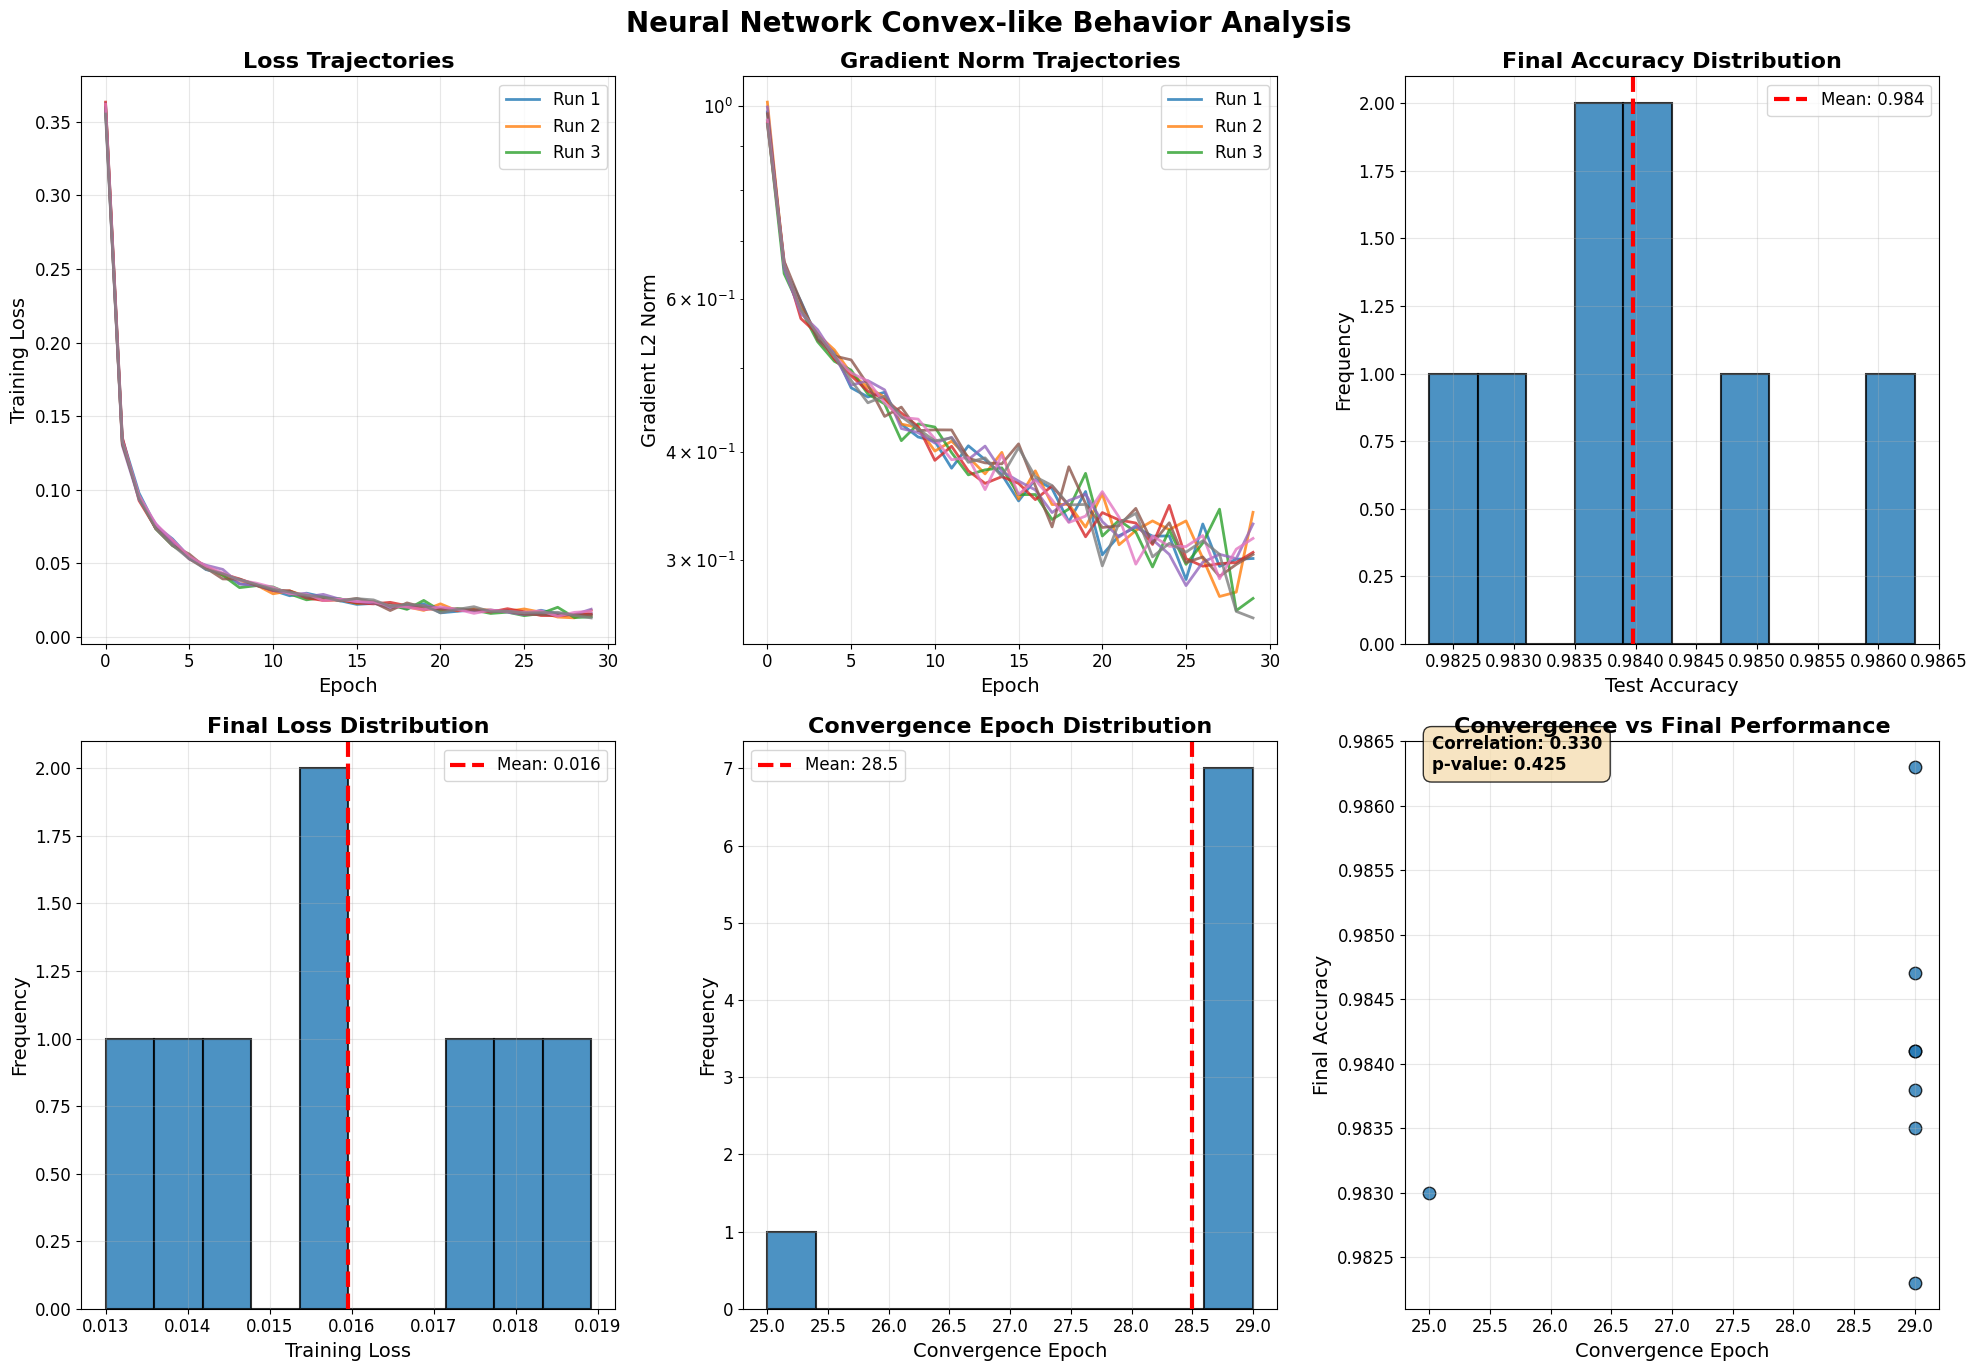


Convex-like Behavior Score: 0.974
(Higher score indicates more convex-like behavior)

Testing Mode Connectivity...
Testing connectivity between 8 pairs of models
Testing pair 1/8: Model 3 ↔ Model 8
  Max loss ratio: 115.412, Barrier height: 1.5762
Testing pair 2/8: Model 1 ↔ Model 8
  Max loss ratio: 104.484, Barrier height: 1.6381
Testing pair 3/8: Model 3 ↔ Model 7
  Max loss ratio: 100.768, Barrier height: 1.7498
Testing pair 4/8: Model 5 ↔ Model 7
  Max loss ratio: 96.232, Barrier height: 1.8027
Testing pair 5/8: Model 2 ↔ Model 7
  Max loss ratio: 92.346, Barrier height: 1.6641
Testing pair 6/8: Model 6 ↔ Model 7
  Max loss ratio: 93.613, Barrier height: 1.6239
Testing pair 7/8: Model 2 ↔ Model 8
  Max loss ratio: 88.599, Barrier height: 1.5981
Testing pair 8/8: Model 1 ↔ Model 6
  Max loss ratio: 96.870, Barrier height: 1.5168

Mode Connectivity Analysis:
------------------------------
Loss Barrier Analysis:
  Max Loss Ratios - Mean: 98.540, Std: 7.862
  Barrier Heights - Mean: 

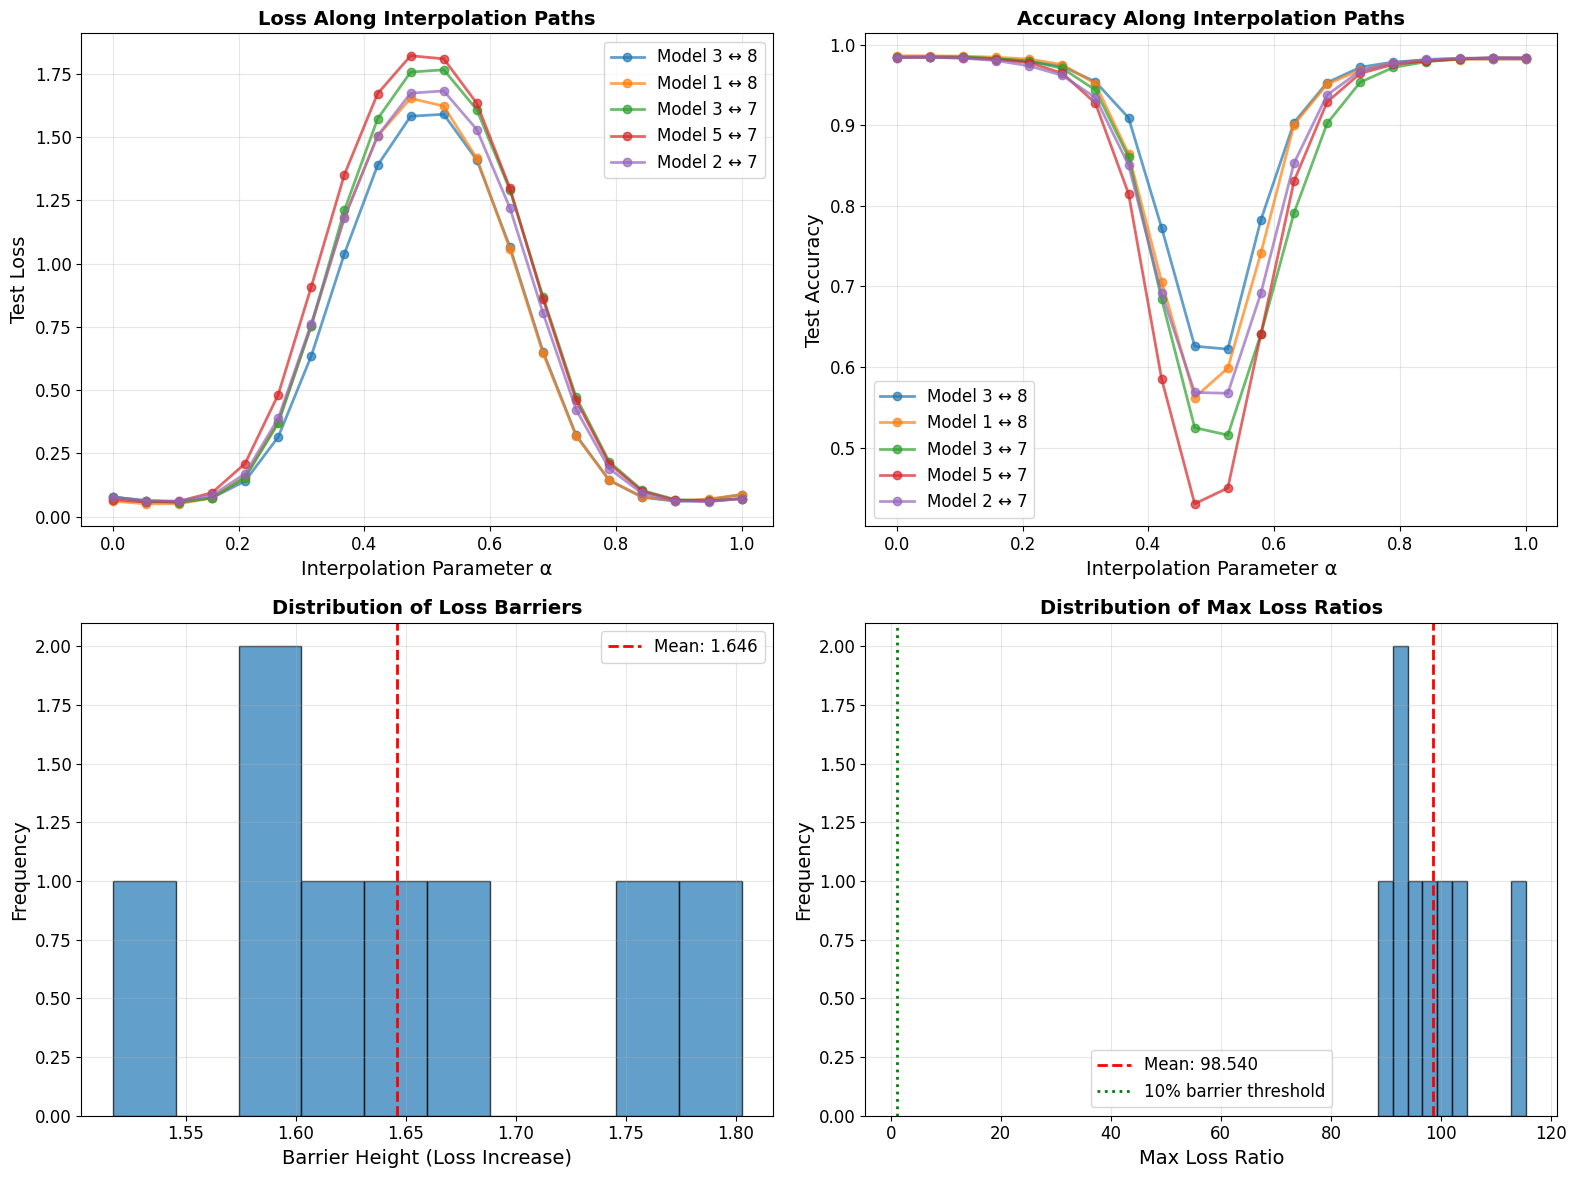


EXPERIMENT SUMMARY
Mode Connectivity Results:
  Average loss barrier: 1.6462 ± 0.0866
  Average max loss ratio: 98.540 ± 7.862
  Connectivity rate: 0.0% (0/8 pairs)
  → WEAK evidence for mode connectivity

Overall Assessment:
  Performance consistency: 0.0011 std
  Gradient correlation: 0.9891
  CONCLUSION: Results show LIMITED support for mode connectivity
  → Multiple solutions exist but may have significant loss barriers


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10):
        super(MLP, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.network(x)

class ConvexBehaviorExperiment:
    def __init__(self, num_runs=10, epochs=50, lr=0.001):
        self.num_runs = num_runs
        self.epochs = epochs
        self.lr = lr
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Load MNIST dataset
        self.load_data()
        
        # Storage for results
        self.results = {
            'loss_trajectories': [],
            'gradient_norms': [],
            'final_weights': [],
            'final_accuracies': [],
            'final_losses': [],
            'convergence_epochs': [],
            'trained_models': []  # Store actual models for connectivity testing
        }
    
    def load_data(self):
        """Load MNIST dataset with specified split"""
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
        # Load full datasets
        full_train = datasets.MNIST('data', train=True, download=True, transform=transform)
        full_test = datasets.MNIST('data', train=False, download=True, transform=transform)
        
        # Create subset with exactly 60k train, 10k test
        train_indices = torch.randperm(len(full_train))[:60000]
        test_indices = torch.randperm(len(full_test))[:10000]
        
        train_subset = torch.utils.data.Subset(full_train, train_indices)
        test_subset = torch.utils.data.Subset(full_test, test_indices)
        
        self.train_loader = DataLoader(train_subset, batch_size=256, shuffle=True)
        self.test_loader = DataLoader(test_subset, batch_size=1000, shuffle=False)
        
        print(f"Train samples: {len(train_subset)}, Test samples: {len(test_subset)}")
    
    def compute_gradient_norm(self, model):
        """Compute L2 norm of gradients"""
        total_norm = 0.0
        for param in model.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        return total_norm ** 0.5
    
    def train_single_model(self, run_id):
        """Train a single model and track metrics"""
        print(f"Training run {run_id + 1}/{self.num_runs}")
        
        # Initialize model with different random seed for each run
        torch.manual_seed(run_id * 1000 + 42)
        model = MLP().to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # Track metrics for this run
        loss_trajectory = []
        gradient_norms = []
        
        for epoch in range(self.epochs):
            model.train()
            epoch_loss = 0.0
            epoch_grad_norm = 0.0
            num_batches = 0
            
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                
                # Track gradient norm
                grad_norm = self.compute_gradient_norm(model)
                epoch_grad_norm += grad_norm
                
                optimizer.step()
                epoch_loss += loss.item()
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches
            avg_grad_norm = epoch_grad_norm / num_batches
            
            loss_trajectory.append(avg_loss)
            gradient_norms.append(avg_grad_norm)
            
            if (epoch + 1) % 10 == 0:
                test_acc = self.evaluate_model(model)
                print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}, Grad_norm={avg_grad_norm:.4f}, Test_acc={test_acc:.4f}")
        
        # Final evaluation
        final_accuracy = self.evaluate_model(model)
        final_loss = loss_trajectory[-1]
        
        # Find convergence epoch (when loss change becomes small)
        convergence_epoch = self.find_convergence_epoch(loss_trajectory)
        
        # Store results
        self.results['loss_trajectories'].append(loss_trajectory)
        self.results['gradient_norms'].append(gradient_norms)
        self.results['final_weights'].append(self.extract_weights(model))
        self.results['final_accuracies'].append(final_accuracy)
        self.results['final_losses'].append(final_loss)
        self.results['convergence_epochs'].append(convergence_epoch)
        self.results['trained_models'].append(model.state_dict())  # Store model state
        
        return model
    
    def evaluate_model(self, model):
        """Evaluate model accuracy on test set"""
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
        
        return correct / total
    
    def evaluate_model_detailed(self, model):
        """Evaluate model and return both loss and accuracy"""
        model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                loss = criterion(output, target)
                total_loss += loss.item()
                
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
                num_batches += 1
        
        avg_loss = total_loss / num_batches
        accuracy = correct / total
        return avg_loss, accuracy
    
    def extract_weights(self, model):
        """Extract flattened weights for comparison"""
        weights = []
        for param in model.parameters():
            weights.extend(param.data.cpu().numpy().flatten())
        return np.array(weights)
    
    def set_model_weights(self, model, weights_vector):
        """Set model weights from a flattened vector"""
        idx = 0
        for param in model.parameters():
            param_shape = param.shape
            param_size = param.numel()
            param.data = torch.tensor(
                weights_vector[idx:idx+param_size].reshape(param_shape),
                dtype=param.dtype,
                device=param.device
            )
            idx += param_size
    
    def find_convergence_epoch(self, loss_trajectory, threshold=0.001):
        """Find epoch where loss change becomes smaller than threshold"""
        for i in range(5, len(loss_trajectory)):
            recent_changes = [abs(loss_trajectory[j] - loss_trajectory[j-1]) 
                            for j in range(i-4, i)]
            if all(change < threshold for change in recent_changes):
                return i
        return len(loss_trajectory) - 1
    
    def test_mode_connectivity(self, num_pairs=5, num_points=20):
        """Test mode connectivity between pairs of trained models"""
        print(f"\nTesting Mode Connectivity...")
        print("="*50)
        
        if len(self.results['final_weights']) < 2:
            print("Need at least 2 trained models to test connectivity")
            return
        
        # Store connectivity results
        connectivity_results = {
            'interpolation_losses': [],
            'interpolation_accuracies': [],
            'pair_indices': [],
            'max_loss_ratios': [],
            'barrier_heights': [],
            'alphas': np.linspace(0, 1, num_points)
        }
        
        # Test connectivity between random pairs
        final_weights = self.results['final_weights']
        num_models = len(final_weights)
        
        # Generate pairs to test
        pairs_to_test = []
        if num_pairs >= num_models * (num_models - 1) // 2:
            # Test all pairs if num_pairs is large enough
            for i in range(num_models):
                for j in range(i + 1, num_models):
                    pairs_to_test.append((i, j))
        else:
            # Random sampling of pairs
            all_pairs = [(i, j) for i in range(num_models) for j in range(i + 1, num_models)]
            pairs_to_test = random.sample(all_pairs, min(num_pairs, len(all_pairs)))
        
        print(f"Testing connectivity between {len(pairs_to_test)} pairs of models")
        
        for pair_idx, (i, j) in enumerate(pairs_to_test):
            print(f"Testing pair {pair_idx + 1}/{len(pairs_to_test)}: Model {i+1} ↔ Model {j+1}")
            
            # Get the two weight configurations
            weights_1 = final_weights[i]
            weights_2 = final_weights[j]
            
            # Get baseline losses (endpoints)
            baseline_loss_1 = self.results['final_losses'][i]
            baseline_loss_2 = self.results['final_losses'][j]
            baseline_acc_1 = self.results['final_accuracies'][i]
            baseline_acc_2 = self.results['final_accuracies'][j]
            
            # Interpolate between the two weight configurations
            alphas = connectivity_results['alphas']
            interpolation_losses = []
            interpolation_accuracies = []
            
            for alpha in alphas:
                # Linear interpolation: w(α) = (1-α)w1 + αw2
                interpolated_weights = (1 - alpha) * weights_1 + alpha * weights_2
                
                # Create a temporary model with interpolated weights
                temp_model = MLP().to(self.device)
                self.set_model_weights(temp_model, interpolated_weights)
                
                # Evaluate loss and accuracy
                loss, accuracy = self.evaluate_model_detailed(temp_model)
                interpolation_losses.append(loss)
                interpolation_accuracies.append(accuracy)
            
            # Store results
            connectivity_results['interpolation_losses'].append(interpolation_losses)
            connectivity_results['interpolation_accuracies'].append(interpolation_accuracies)
            connectivity_results['pair_indices'].append((i, j))
            
            # Compute connectivity metrics
            max_loss = max(interpolation_losses)
            endpoint_loss = max(baseline_loss_1, baseline_loss_2)
            loss_ratio = max_loss / endpoint_loss if endpoint_loss > 0 else float('inf')
            connectivity_results['max_loss_ratios'].append(loss_ratio)
            
            # Compute barrier height (max loss - average endpoint loss)
            avg_endpoint_loss = (baseline_loss_1 + baseline_loss_2) / 2
            barrier_height = max_loss - avg_endpoint_loss
            connectivity_results['barrier_heights'].append(barrier_height)
            
            print(f"  Max loss ratio: {loss_ratio:.3f}, Barrier height: {barrier_height:.4f}")
        
        # Analyze connectivity results
        self.analyze_connectivity_results(connectivity_results)
        
        # Create connectivity visualization
        self.visualize_connectivity(connectivity_results)
        
        return connectivity_results
    
    def analyze_connectivity_results(self, connectivity_results):
        """Analyze mode connectivity results"""
        print(f"\nMode Connectivity Analysis:")
        print("-" * 30)
        
        max_ratios = np.array(connectivity_results['max_loss_ratios'])
        barriers = np.array(connectivity_results['barrier_heights'])
        
        print(f"Loss Barrier Analysis:")
        print(f"  Max Loss Ratios - Mean: {max_ratios.mean():.3f}, Std: {max_ratios.std():.3f}")
        print(f"  Barrier Heights - Mean: {barriers.mean():.4f}, Std: {barriers.std():.4f}")
        
        # Connectivity assessment
        low_barrier_threshold = 0.1  # 10% increase in loss
        connected_pairs = np.sum(max_ratios < (1 + low_barrier_threshold))
        total_pairs = len(max_ratios)
        
        print(f"\nConnectivity Assessment:")
        print(f"  Pairs with low barriers (<{low_barrier_threshold*100}% loss increase): {connected_pairs}/{total_pairs}")
        print(f"  Connectivity rate: {connected_pairs/total_pairs*100:.1f}%")
        
        if connected_pairs / total_pairs > 0.8:
            print("  → Strong evidence for mode connectivity")
        elif connected_pairs / total_pairs > 0.5:
            print("  → Moderate evidence for mode connectivity")
        else:
            print("  → Weak evidence for mode connectivity")
    
    def visualize_connectivity(self, connectivity_results):
        """Create visualizations for mode connectivity"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Loss interpolation paths
        ax = axes[0, 0]
        alphas = connectivity_results['alphas']
        for i, losses in enumerate(connectivity_results['interpolation_losses'][:5]):  # Show first 5 pairs
            pair_indices = connectivity_results['pair_indices'][i]
            ax.plot(alphas, losses, 'o-', alpha=0.7, linewidth=2, 
                   label=f'Model {pair_indices[0]+1} ↔ {pair_indices[1]+1}')
        ax.set_title('Loss Along Interpolation Paths', fontsize=14, fontweight='bold')
        ax.set_xlabel('Interpolation Parameter α')
        ax.set_ylabel('Test Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Accuracy interpolation paths
        ax = axes[0, 1]
        for i, accuracies in enumerate(connectivity_results['interpolation_accuracies'][:5]):
            pair_indices = connectivity_results['pair_indices'][i]
            ax.plot(alphas, accuracies, 'o-', alpha=0.7, linewidth=2,
                   label=f'Model {pair_indices[0]+1} ↔ {pair_indices[1]+1}')
        ax.set_title('Accuracy Along Interpolation Paths', fontsize=14, fontweight='bold')
        ax.set_xlabel('Interpolation Parameter α')
        ax.set_ylabel('Test Accuracy')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Barrier height distribution
        ax = axes[1, 0]
        ax.hist(connectivity_results['barrier_heights'], bins=10, alpha=0.7, edgecolor='black')
        ax.set_title('Distribution of Loss Barriers', fontsize=14, fontweight='bold')
        ax.set_xlabel('Barrier Height (Loss Increase)')
        ax.set_ylabel('Frequency')
        mean_barrier = np.mean(connectivity_results['barrier_heights'])
        ax.axvline(mean_barrier, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_barrier:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Loss ratio distribution
        ax = axes[1, 1]
        ax.hist(connectivity_results['max_loss_ratios'], bins=10, alpha=0.7, edgecolor='black')
        ax.set_title('Distribution of Max Loss Ratios', fontsize=14, fontweight='bold')
        ax.set_xlabel('Max Loss Ratio')
        ax.set_ylabel('Frequency')
        mean_ratio = np.mean(connectivity_results['max_loss_ratios'])
        ax.axvline(mean_ratio, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_ratio:.3f}')
        ax.axvline(1.1, color='green', linestyle=':', linewidth=2,
                  label='10% barrier threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('mode_connectivity_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_experiment(self):
        """Run the full experiment"""
        print("Starting Convex-like Behavior Experiment")
        print("="*50)
        
        for run_id in range(self.num_runs):
            self.train_single_model(run_id)
        
        self.analyze_results()
        
        # Test mode connectivity
        connectivity_results = self.test_mode_connectivity(num_pairs=min(10, self.num_runs), num_points=20)
        
        return connectivity_results
    
    def analyze_results(self):
        """Analyze results to test convex-like behavior"""
        print("\nAnalyzing Results...")
        print("="*50)
        
        # 1. Consistency of final performance (convex-like property)
        final_accs = np.array(self.results['final_accuracies'])
        final_losses = np.array(self.results['final_losses'])
        
        print(f"Final Accuracy - Mean: {final_accs.mean():.4f}, Std: {final_accs.std():.4f}")
        print(f"Final Loss - Mean: {final_losses.mean():.4f}, Std: {final_losses.std():.4f}")
        print(f"Accuracy Range: {final_accs.max() - final_accs.min():.4f}")
        print(f"Loss Range: {final_losses.max() - final_losses.min():.4f}")
        
        # 2. Convergence consistency
        conv_epochs = np.array(self.results['convergence_epochs'])
        print(f"Convergence Epoch - Mean: {conv_epochs.mean():.1f}, Std: {conv_epochs.std():.1f}")
        
        # 3. Weight similarity analysis
        self.analyze_weight_similarity()
        
        # 4. Gradient behavior analysis
        self.analyze_gradient_behavior()
        
        # 5. Create visualizations (only the main figure with 6 subplots)
        self.create_visualizations()
        
        # 6. Convex-like behavior score
        convex_score = self.compute_convex_score()
        print(f"\nConvex-like Behavior Score: {convex_score:.3f}")
        print("(Higher score indicates more convex-like behavior)")
    
    def analyze_weight_similarity(self):
        """Analyze similarity between final weights of different runs"""
        print(f"\nWeight Similarity Analysis:")
        
        final_weights = self.results['final_weights']
        similarities = []
        
        for i in range(len(final_weights)):
            for j in range(i+1, len(final_weights)):
                # Compute cosine similarity
                w1, w2 = final_weights[i], final_weights[j]
                similarity = np.dot(w1, w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
                similarities.append(similarity)
        
        similarities = np.array(similarities)
        print(f"Weight Cosine Similarity - Mean: {similarities.mean():.4f}, Std: {similarities.std():.4f}")
        
        # Also compute pairwise L2 distances (normalized)
        distances = []
        for i in range(len(final_weights)):
            for j in range(i+1, len(final_weights)):
                w1, w2 = final_weights[i], final_weights[j]
                distance = np.linalg.norm(w1 - w2) / (np.linalg.norm(w1) + np.linalg.norm(w2))
                distances.append(distance)
        
        distances = np.array(distances)
        print(f"Normalized Weight Distance - Mean: {distances.mean():.4f}, Std: {distances.std():.4f}")
    
    def analyze_gradient_behavior(self):
        """Analyze gradient behavior across runs"""
        print(f"\nGradient Behavior Analysis:")
        
        # Check if gradient norms follow similar patterns
        all_grad_norms = np.array(self.results['gradient_norms'])
        
        # Compute correlation between gradient trajectories of different runs
        correlations = []
        for i in range(len(all_grad_norms)):
            for j in range(i+1, len(all_grad_norms)):
                corr, _ = pearsonr(all_grad_norms[i], all_grad_norms[j])
                correlations.append(corr)
        
        correlations = np.array(correlations)
        print(f"Gradient Trajectory Correlation - Mean: {correlations.mean():.4f}, Std: {correlations.std():.4f}")
        
        # Final gradient norms
        final_grad_norms = [norms[-1] for norms in self.results['gradient_norms']]
        print(f"Final Gradient Norms - Mean: {np.mean(final_grad_norms):.6f}, Std: {np.std(final_grad_norms):.6f}")
    
    def compute_convex_score(self):
        """Compute a score indicating how convex-like the behavior is"""
        # Combine multiple metrics into a single score
        
        # 1. Consistency of final performance (lower variance = more convex-like)
        acc_consistency = 1 / (1 + np.std(self.results['final_accuracies']))
        loss_consistency = 1 / (1 + np.std(self.results['final_losses']))
        
        # 2. Convergence consistency
        conv_consistency = 1 / (1 + np.std(self.results['convergence_epochs']) / 10)
        
        # 3. Gradient correlation (higher = more similar paths)
        all_grad_norms = np.array(self.results['gradient_norms'])
        correlations = []
        for i in range(len(all_grad_norms)):
            for j in range(i+1, len(all_grad_norms)):
                corr, _ = pearsonr(all_grad_norms[i], all_grad_norms[j])
                correlations.append(corr)
        grad_similarity = np.mean(correlations)
        
        # Combine scores (weights can be adjusted)
        convex_score = (0.3 * acc_consistency + 0.3 * loss_consistency + 
                       0.2 * conv_consistency + 0.2 * grad_similarity)
        
        return convex_score
    
    def create_visualizations(self):
        """Create visualizations of the results with enhanced font sizes for reports"""
        # Set global font sizes for matplotlib
        plt.rcParams.update({
            'font.size': 14,          # Base font size
            'axes.titlesize': 16,     # Subplot titles
            'axes.labelsize': 14,     # Axis labels
            'xtick.labelsize': 12,    # X-axis tick labels
            'ytick.labelsize': 12,    # Y-axis tick labels
            'legend.fontsize': 12,    # Legend
            'figure.titlesize': 18    # Main title
        })
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 14))  # Increased figure size
        fig.suptitle('Neural Network Convex-like Behavior Analysis', fontsize=20, fontweight='bold')
        
        # 1. Loss trajectories
        ax = axes[0, 0]
        for i, trajectory in enumerate(self.results['loss_trajectories']):
            ax.plot(trajectory, alpha=0.8, linewidth=2, label=f'Run {i+1}' if i < 3 else '')
        ax.set_title('Loss Trajectories', fontsize=16, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Training Loss', fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=12)
        
        # 2. Gradient norms
        ax = axes[0, 1]
        for i, grad_norms in enumerate(self.results['gradient_norms']):
            ax.plot(grad_norms, alpha=0.8, linewidth=2, label=f'Run {i+1}' if i < 3 else '')
        ax.set_title('Gradient Norm Trajectories', fontsize=16, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Gradient L2 Norm', fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        ax.tick_params(labelsize=12)
        
        # 3. Final performance distribution
        ax = axes[0, 2]
        ax.hist(self.results['final_accuracies'], bins=10, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax.set_title('Final Accuracy Distribution', fontsize=16, fontweight='bold')
        ax.set_xlabel('Test Accuracy', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        mean_acc = np.mean(self.results['final_accuracies'])
        ax.axvline(mean_acc, color='red', linewidth=3,
                  linestyle='--', label=f'Mean: {mean_acc:.3f}')
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=12)
        
        # 4. Final loss distribution
        ax = axes[1, 0]
        ax.hist(self.results['final_losses'], bins=10, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax.set_title('Final Loss Distribution', fontsize=16, fontweight='bold')
        ax.set_xlabel('Training Loss', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        mean_loss = np.mean(self.results['final_losses'])
        ax.axvline(mean_loss, color='red', linewidth=3,
                  linestyle='--', label=f'Mean: {mean_loss:.3f}')
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=12)
        
        # 5. Convergence epochs
        ax = axes[1, 1]
        ax.hist(self.results['convergence_epochs'], bins=10, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax.set_title('Convergence Epoch Distribution', fontsize=16, fontweight='bold')
        ax.set_xlabel('Convergence Epoch', fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        mean_conv = np.mean(self.results['convergence_epochs'])
        ax.axvline(mean_conv, color='red', linewidth=3,
                  linestyle='--', label=f'Mean: {mean_conv:.1f}')
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=12)
        
        # 6. Performance vs convergence scatter
        ax = axes[1, 2]
        ax.scatter(self.results['convergence_epochs'], self.results['final_accuracies'], 
                  alpha=0.8, s=80, edgecolors='black', linewidth=1)
        ax.set_title('Convergence vs Final Performance', fontsize=16, fontweight='bold')
        ax.set_xlabel('Convergence Epoch', fontsize=14)
        ax.set_ylabel('Final Accuracy', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=12)
        
        # Add correlation coefficient with larger text
        corr, p_val = pearsonr(self.results['convergence_epochs'], self.results['final_accuracies'])
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}\np-value: {p_val:.3f}', 
               transform=ax.transAxes, fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.5))
        
        plt.tight_layout()
        
        # Save the figure in high resolution for reports
        plt.savefig('convex_behavior_analysis.png', dpi=300, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
        plt.savefig('convex_behavior_analysis.pdf', bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
        
        plt.show()

# Run the experiment
if __name__ == "__main__":
    # Create and run experiment
    experiment = ConvexBehaviorExperiment(num_runs=8, epochs=30, lr=0.001)
    connectivity_results = experiment.run_experiment()
    
    # Print final summary
    print("\n" + "="*60)
    print("EXPERIMENT SUMMARY")
    print("="*60)
    
    if connectivity_results:
        # Mode connectivity summary
        max_ratios = np.array(connectivity_results['max_loss_ratios'])
        barriers = np.array(connectivity_results['barrier_heights'])
        
        print(f"Mode Connectivity Results:")
        print(f"  Average loss barrier: {barriers.mean():.4f} ± {barriers.std():.4f}")
        print(f"  Average max loss ratio: {max_ratios.mean():.3f} ± {max_ratios.std():.3f}")
        
        # Determine connectivity strength
        low_barrier_pairs = np.sum(max_ratios < 1.1)  # 10% threshold
        total_pairs = len(max_ratios)
        connectivity_rate = low_barrier_pairs / total_pairs
        
        print(f"  Connectivity rate: {connectivity_rate*100:.1f}% ({low_barrier_pairs}/{total_pairs} pairs)")
        
        if connectivity_rate > 0.8:
            print("  → STRONG evidence for mode connectivity")
        elif connectivity_rate > 0.5:
            print("  → MODERATE evidence for mode connectivity")
        else:
            print("  → WEAK evidence for mode connectivity")
    
    print(f"\nOverall Assessment:")
    print(f"  Performance consistency: {np.std(experiment.results['final_accuracies']):.4f} std")
    print(f"  Gradient correlation: {np.corrcoef([g for g in experiment.results['gradient_norms']])[0,1]:.4f}")
    
    if connectivity_results and connectivity_rate > 0.7:
        print(f"  CONCLUSION: Results SUPPORT mode connectivity theory")
        print(f"  → Multiple solutions exist with low-loss connecting paths")
    else:
        print(f"  CONCLUSION: Results show LIMITED support for mode connectivity")
        print(f"  → Multiple solutions exist but may have significant loss barriers")